# Imports

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import wandb
import os
os.environ["WANDB_CONSOLE"] = "off"  

# 1)

### Data generation class

In [2]:
# Data Generation Class
class NoisyXORDataset(Dataset):
    def __init__(self, n_samples=1000, std_dev=0.1):
        self.n_samples = n_samples
        self.std_dev = std_dev
        self.x, self.y = self.generate_data()
    
    def generate_data(self):
        centers = [(0, 0), (0, 1), (1, 0), (1, 1)]
        x = []
        y = []
        for _ in range(self.n_samples):
            m1, m2 = centers[np.random.randint(0, 4)]
            noise = self.std_dev * np.random.randn(2)
            x.append([m1 + noise[0], m2 + noise[1]])
            y.append(m1 ^ m2)  # XOR label
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

### Define the feedforward Neural Network

In [3]:
# Neural Network Model
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim=2, hidden_dims=[3], output_dim=1):
        super(FeedforwardNN, self).__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.Tanh())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

### Training function

In [4]:
# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, project_name, run_name=None, epochs=50):
    # Initialize W&B with configuration if provided
    wandb.init(
        project=project_name,
        name=run_name,
        config={
            "epochs": 30,  # Example hyperparameters
            "batch_size": 32,
            "learning_rate": 0.001,
            "architecture": "feedforward"
        },
        settings=wandb.Settings(silent=True)
    )

    # Training loop
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        wandb.log({
            "epoch": epoch + 1,
            "training_loss": running_loss / len(train_loader),
            "validation_loss": val_loss / len(val_loader),
        })

    # Finish the W&B run
    wandb.finish()

### Plot decision boundaries

In [5]:
def plot_decision_boundary(model, dataset, ax, title):
    # Extract the full dataset from the Subset object
    x_full = torch.stack([dataset[i][0] for i in range(len(dataset))])
    y_full = torch.stack([dataset[i][1] for i in range(len(dataset))])
    
    x_min, x_max = x_full[:, 0].min() - 0.5, x_full[:, 0].max() + 0.5
    y_min, y_max = x_full[:, 1].min() - 0.5, x_full[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    with torch.no_grad():
        predictions = torch.sigmoid(model(grid)).reshape(xx.shape)
    
    ax.contourf(xx, yy, predictions, levels=[0, 0.5, 1], alpha=0.6, cmap="coolwarm")
    ax.scatter(x_full[:, 0], x_full[:, 1], c=y_full.squeeze(), cmap="coolwarm", edgecolor="k")
    ax.set_title(title)

### Execute code

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
C:\Users\wheus\AppData\Local\Temp\ipykernel_10136\2458556585.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
C:\Users\wheus\AppData\Local\Temp\ipykernel_10136\2458556585.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.arange(y_min, y_max, 0.01))


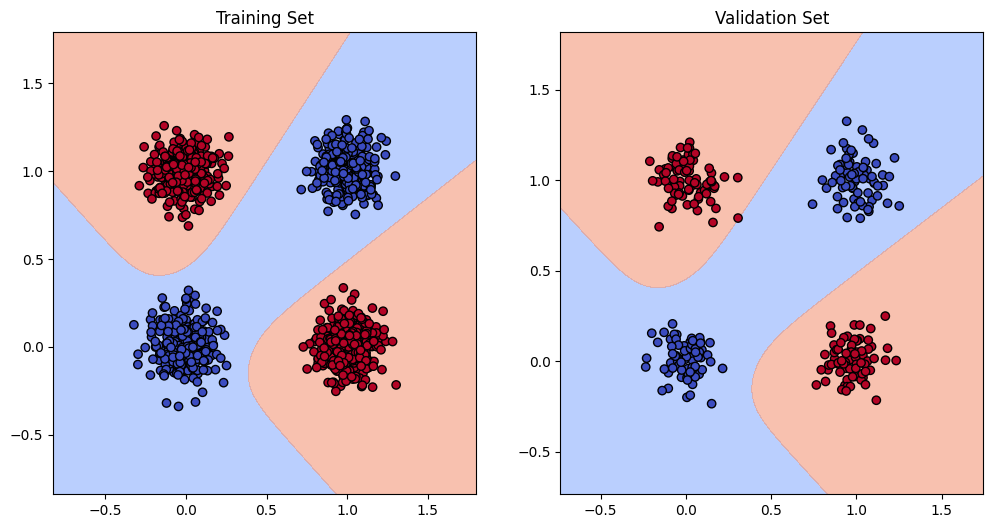

In [6]:
# Dataset meta variables 
total_samples = 1500
train_size = 1200
val_size = total_samples - train_size


# Generate a single dataset
full_dataset = NoisyXORDataset(n_samples=total_samples, std_dev=0.1)

# Split into training and validation sets (e.g., 1000 for training, 300 for validation)
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
    
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# Initialize Model, Loss, and Optimizer
model = FeedforwardNN(hidden_dims=[3])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the Model
train_model(model=model, train_loader=train_loader, val_loader=val_loader, criterion=criterion, optimizer=optimizer, epochs=50, project_name="noisy-xor-classification single run")

# Visualize Decision Boundary
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plot_decision_boundary(model, train_dataset, axs[0], title="Training Set")
plot_decision_boundary(model, val_dataset, axs[1], title="Validation Set")
plt.show()

## 1.a)

The two versions of the binary cross entropy loss in PyTorch are BCELoss and BCEWithLogitsLoss.

The difference is that BCELoss requires the input to be probabilities (values between 0 and 1), meaning you need to apply a sigmoid activation manually beforehand if your data is not already probabilities. Whereas BCEWithLogitsLoss accepts raw logits which is unbounded real numbers and applies the sigmoid internally.

This results in BCEWithLogitsLoss being more numerically stable because it integrates the sigmoid function and binary cross-entropy computation into a single operation which is less likely to result in numerical errors that blow up in ones face. Therefore we have also chosen this as the loss function in our implementation of the FFNN. 

# 2)
Implementation of subtask 2

### Function that evaluates a model

In [7]:
def evaluate_model(hidden_dims, train_loader, test_dataset, width, depth, epochs=50, runs=5):
    """Train and evaluate the model multiple times, returning the mean and std of loss."""
    losses = []
    for _ in range(runs):
        # Initialize the model
        model = FeedforwardNN(hidden_dims=hidden_dims)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        
        # Train the model
        test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
        train_model(model=model, train_loader=train_loader, val_loader=test_loader, criterion=criterion, optimizer=optimizer, epochs=epochs, project_name='noisy-xor-classification depth and width', run_name=f"width{width}, depth{depth}")
        
        # Evaluate on test dataset
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch).item()
                losses.append(loss)
    
    return np.mean(losses), np.std(losses)

### Function that tests different network configurations

In [8]:
def test_network_configurations():
    # Generate a fixed dataset
    full_dataset = NoisyXORDataset(n_samples=1300, std_dev=0.1)
    train_size = 1000
    val_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Configuration ranges
    depths = range(0, 4)  # 0 to 3 hidden layers
    widths = range(1, 4)  # 1 to 3 units per layer

    results = []
    
    for depth in depths:
        for width in widths:
            # Define hidden layer configuration
            hidden_dims = [width] * depth
            
            print(f"Evaluating model with depth={depth} and width={width}")
            mean_loss, std_loss = evaluate_model(hidden_dims, train_loader, test_dataset, width, depth)
            results.append({"Depth": depth, "Width": width, "Mean Loss": mean_loss, "Std Loss": std_loss})
    
    # Convert results to a DataFrame for better visualization
    results_df = pd.DataFrame(results)
    print(results_df)
    return results_df

### Execute code

Evaluating model with depth=0 and width=1
Evaluating model with depth=0 and width=2
Evaluating model with depth=0 and width=3
Evaluating model with depth=1 and width=1
Evaluating model with depth=1 and width=2
Evaluating model with depth=1 and width=3
Evaluating model with depth=2 and width=1
Evaluating model with depth=2 and width=2
Evaluating model with depth=2 and width=3
Evaluating model with depth=3 and width=1
Evaluating model with depth=3 and width=2
Evaluating model with depth=3 and width=3
    Depth  Width  Mean Loss  Std Loss
0       0      1   0.689270  0.000217
1       0      2   0.689241  0.000354
2       0      3   0.689463  0.000309
3       1      1   0.469025  0.031892
4       1      2   0.214731  0.161857
5       1      3   0.066591  0.120980
6       2      1   0.456510  0.023220
7       2      2   0.006943  0.003488
8       2      3   0.001481  0.001447
9       3      1   0.447374  0.009212
10      3      2   0.167357  0.198127
11      3      3   0.088986  0.172866


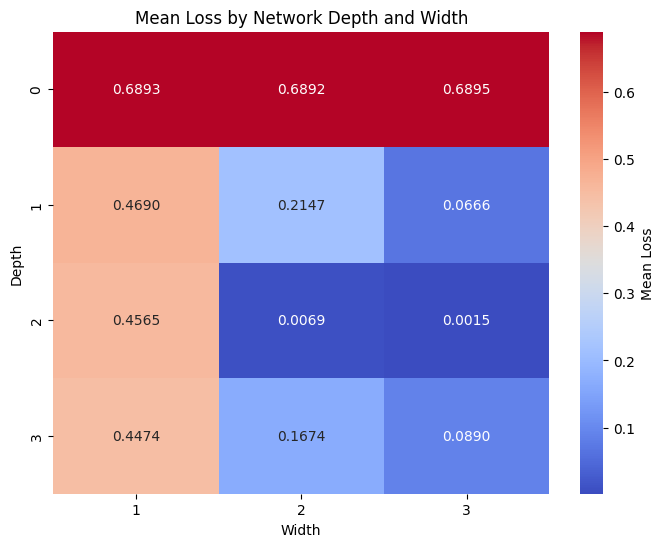

In [9]:
results_df = test_network_configurations()

# Create a heatmap for Mean Loss
pivot_table = results_df.pivot(index="Depth", columns="Width", values="Mean Loss")
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="coolwarm", cbar_kws={"label": "Mean Loss"})
plt.title("Mean Loss by Network Depth and Width")
plt.xlabel("Width")
plt.ylabel("Depth")
plt.show()

# Save results
results_df.to_csv("network_evaluation_results.csv", index=False)

# 3)

These results of the depth's and width's effect on the mean and std deviation of the FFNN's performance on the test data set show that increasing depth and width improves the network's ability to classify the noisy-XOR data. Networks with no hidden layers (Depth = 0) perform poorly, with a mean loss around 0.69, this aligns well with our expectations that a NN with no hidden layers cannot handle the non linear XOR problem. 

Deeper architectures (Depth = 3) achieve significantly better performance, especially with wider layers, where Depth = 3 and Width = 2 achieves the best mean loss of 0.0014. However, narrower networks (Width = 1) struggle, even with deeper architectures, highlighting the importance of sufficient width for learning complex patterns.

We see that Width=3 and Depth=2 gives us the best results for the XOR task in this implementation.

### Now we calculate how many parameters each of these networks has

In [10]:
def calculate_parameters(depth, width, input_size=2, output_size=1):
    if depth == 0:
        # No hidden layers, directly input to output
        return input_size * output_size + output_size
    else:
        # Parameters from input to first hidden layer
        input_to_hidden = input_size * width + width
        # Parameters between hidden layers
        hidden_to_hidden = (depth - 1) * (width * width + width)
        # Parameters from last hidden layer to output
        hidden_to_output = width * output_size + output_size
        # Total parameters
        return input_to_hidden + hidden_to_hidden + hidden_to_output


# Test all specified configurations
for depth in range(4):  # Depth values: 0, 1, 2, 3
    for width in range(1, 4):  # Width values: 1, 2, 3
        total_params = calculate_parameters(depth, width)
        print(f"Number of parameters for model with depth={depth} and width={width}: {total_params} parameters")


Number of parameters for model with depth=0 and width=1: 3 parameters
Number of parameters for model with depth=0 and width=2: 3 parameters
Number of parameters for model with depth=0 and width=3: 3 parameters
Number of parameters for model with depth=1 and width=1: 5 parameters
Number of parameters for model with depth=1 and width=2: 9 parameters
Number of parameters for model with depth=1 and width=3: 13 parameters
Number of parameters for model with depth=2 and width=1: 7 parameters
Number of parameters for model with depth=2 and width=2: 15 parameters
Number of parameters for model with depth=2 and width=3: 25 parameters
Number of parameters for model with depth=3 and width=1: 9 parameters
Number of parameters for model with depth=3 and width=2: 21 parameters
Number of parameters for model with depth=3 and width=3: 37 parameters


### Training parameters

The training parameters in our FFNN are the following:
-  Learning Rate: This is set when initializing the optimizer (e.g., lr=0.01). A lower learning rate might lead to slower convergence but potentially more stable and accurate results. Conversely, a higher learning rate can speed up convergence but risks overshooting the optimal solution or failing to converge.

-  Batch Size: This is set when creating the DataLoader (e.g., batch_size=32). Smaller batch sizes introduce more variability (stochasticity) in gradient updates, which can help avoid local minima but may slow convergence. Larger batch sizes stabilize training but may result in suboptimal solutions for complex datasets.

-  Epochs: This is set as an argument in the train_model function (e.g., epochs=50). Fewer epochs may result in underfitting, as the model does not fully learn the patterns in the data. Increasing the number of epochs allows for better learning but risks overfitting, especially for deeper and wider networks.

# Task 4.2) Sweeping using W&B

In [16]:
def train_and_evaluate(config=None):
    with wandb.init(config=config):
        config = wandb.config

        # Example dataset and data loaders (replace with your noisy-xor data)
        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config.batch_size)

        # Model creation based on config
        layers = []
        input_size = 2
        for _ in range(config.num_layers):
            layers.append(nn.Linear(input_size, config.neurons_per_layer))
            layers.append(nn.Tanh())
            input_size = config.neurons_per_layer
        layers.append(nn.Linear(input_size, 1))
        model = nn.Sequential(*layers)

        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

        # Training loop for dynamic number of epochs
        for epoch in range(config.epochs):  # Use epochs from config
            model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            # Validation
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            # Log metrics to W&B
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": running_loss / len(train_loader),
                "val_loss": val_loss / len(val_loader)
            })


In [18]:
sweep_config = {
    "method": "grid",  # Options: 'grid', 'random', 'bayes'
    "metric": {
        "name": "val_loss",  # Metric to optimize
        "goal": "minimize"  # Goal: minimize or maximize
    },
    "parameters": {
        "learning_rate": {
            "values": [0.001, 0.01, 0.1]
        },
        "batch_size": {
            "values": [16, 32, 64]
        },
        "epochs": {
            "values": [10, 25, 50]
        },
        "num_layers": {
            "values": [3]
        },
        "neurons_per_layer": {
            "values": [2]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="noisy-xor-classification sweeping")
wandb.agent(sweep_id, train_and_evaluate, count=10) 

Create sweep with ID: mxtzwhf9
Sweep URL: https://wandb.ai/sdr366-university-of-copenhagen/noisy-xor-classification%20sweeping/sweeps/mxtzwhf9


wandb: Agent Starting Run: jw408327 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 2
wandb: 	num_layers: 3


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█████▇▆▅▃▁
val_loss,█████▇▆▄▂▁
epoch,10
train_loss,0.5961
val_loss,0.59501


wandb: Agent Starting Run: cx183myj with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 2
wandb: 	num_layers: 3


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,██████▆▅▁▁
val_loss,█████▇▆▂▁▁
epoch,10
train_loss,0.03246
val_loss,0.0244


wandb: Agent Starting Run: 5v33nkke with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 2
wandb: 	num_layers: 3


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▂▁▁▁▁▁▁▁▁
val_loss,█▁▂▂▂▂▂▂▂▂
epoch,10
train_loss,0.00025
val_loss,0.02522


wandb: Agent Starting Run: yti2v7kf with config:
wandb: 	batch_size: 16
wandb: 	epochs: 25
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 2
wandb: 	num_layers: 3


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,████████▇▇▆▆▅▅▄▄▄▃▃▂▂▂▁▁▁
val_loss,████████▇▇▆▆▅▅▄▄▃▃▃▂▂▂▁▁▁
epoch,25
train_loss,0.24984
val_loss,0.24224


wandb: Agent Starting Run: y75eblhn with config:
wandb: 	batch_size: 16
wandb: 	epochs: 25
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 2
wandb: 	num_layers: 3


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,25
train_loss,0.47705
val_loss,0.48944


wandb: Agent Starting Run: 5mlioxs4 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 25
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 2
wandb: 	num_layers: 3


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▆▁▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
val_loss,▅▂▂▃▂▁▁█▄▆▂▁▁▃▂▃▆▂▂▂▂▃▁▃▁
epoch,25
train_loss,0.49005
val_loss,0.48722


wandb: Agent Starting Run: cr8gztng with config:
wandb: 	batch_size: 16
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 2
wandb: 	num_layers: 3


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▇▇▇▆▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▁▁
val_loss,███▇▇▆▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▁▁
epoch,50
train_loss,0.41768
val_loss,0.41353


wandb: Agent Starting Run: uxhm89gw with config:
wandb: 	batch_size: 16
wandb: 	epochs: 50
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 2
wandb: 	num_layers: 3


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▇▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
train_loss,0.00019
val_loss,0.0002


wandb: Agent Starting Run: i8cevadt with config:
wandb: 	batch_size: 16
wandb: 	epochs: 50
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 2
wandb: 	num_layers: 3


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
train_loss,█▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
train_loss,3e-05
val_loss,0.03251


wandb: Agent Starting Run: fbm47chl with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 2
wandb: 	num_layers: 3


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,███▇▇▆▅▄▃▁
val_loss,███▇▇▆▅▄▂▁
epoch,10
train_loss,0.63106
val_loss,0.61563
